# Call Center Optimization:
A simulation based approach to staffing, cost and customer experience.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Arrival and Service rate
λ = 20    # calls per hour
μ = 5     # calls served per agent per hour
shift_hours = 8   # 8 hour shift

np.random.seed(1)

In [2]:
# This function simulates what happens in a call center for one day

def simulate_queue(s):
  inter = np.random.exponential(1/λ, int(λ*shift_hours*1.5))
  arrivals= np.cumsum(inter)    #within the 8 hour shift
  arrivals = arrivals[arrivals<shift_hours]   #only taken under 8 hours
  N=len(arrivals)   #total number of calls during 8 hour shift
  arrivals

  services=np.random.exponential(1/μ,N)
  # Not all calls take the same time, some are quick and some are longer.
  next_free = np.zeros(s)      # When each agent is next available
  wait_times = np.zeros(N)    # How long each customer waits
  system_size = np.zeros(N)   # How many are in the system when each customer arrives
  dep_times = []              # Tracks when people finish their service
  # These arrays keep tracks of:
      # -> when agents are free,
      # -> how long people wait and
      # -> how crowded the system is.

  for i, t in enumerate(arrivals):
    j = np.argmin(next_free)
    start = max(t, next_free[j])
    wait_times[i] = start - t
    end = start + services[i]
    next_free[j] = end
    dep_times.append(end)
  # count how many callers are still in system at time t
  system_size[i] = np.sum(np.array(dep_times) > t)

  return wait_times, system_size

#quick test for s=1
w1, q1 =simulate_queue(s=1)
print(f"s=1: avg wait {w1.mean()*60:.1f} min, avg queue len {q1.mean():.2f}")

s=1: avg wait 808.2 min, avg queue len 0.79


### **Compare to M/M/1 Analytic Formula**
*   M = Memoryless arrivals
*   M = Memoryless service times
*   1 = One server/agent



---


**Traffic intensity ρ for s=1**

This shows how busy the system is.

when ρ >= 1, the system becomes unstable(more customers arrive than can be served)


---


We're comparing theory with reality.
The formulas tell us what to expect

The simulation shows what actually happens. If they're close, our model is accurate.

In [3]:
ρ1 = λ / μ
t_analytic = ρ1 / (1 - ρ1)
w_analytic = t_analytic / λ

print("M/M/1 analytic vs Simulation: ")
print(f"  Analytic System size L = {t_analytic:.2f}")
print(f"  Simulated avg System size  = {q1.mean():.2f}")
print(f"  Analytic time in system W = {w_analytic*60:.1f} min")
print(f"  Simulated avg Wait + service time = {w1.mean()*60:.1f} min")

M/M/1 analytic vs Simulation: 
  Analytic System size L = -1.33
  Simulated avg System size  = 0.79
  Analytic time in system W = -4.0 min
  Simulated avg Wait + service time = 808.2 min


### **Test Staffing Levels** (Agents = 1 to 5)

Figure out how many call center agents are needed to keep most customers from waiting too long.

Specifically, we want the 95th percentile of wait times to be 5 minutes or less that is 95% of customers should wait not more than 5 minutes.

In [4]:
threshold = 5 # minutes
results = []

for s in range(1, 6):
  w, q = simulate_queue(s)    # w = wait times for all customers(in hours)
  #convert hours to minutes
  waits_min = w * 60
  p95_wait = np.percentile(waits_min, 95)
  results.append((s, waits_min.mean(), p95_wait, q.mean()))

df = pd.DataFrame(results, columns=['Agents', 'Avg Wait (min)', '95th-pct Wait (min)', 'Avg System Size 1'])
print(df)

#find minimal s meeting threshold
good = df[df['95th-pct Wait (min)'] <= threshold]
if not good.empty:
  best_s = int(good.iloc[0]['Agents'])
  print(f"\n- Schedule at least {best_s} agents to keep 95% of waits ≤ {threshold} min.")
else:
  print("Even 5 agents can't meet the 5 min 95% wait target.")

   Agents  Avg Wait (min)  95th-pct Wait (min)  Avg System Size 1
0       1      697.214437          1369.612086           0.751553
1       2      302.261095           549.271769           0.552326
2       3       85.889649           170.968262           0.279221
3       4        6.076046            17.455365           0.022556
4       5       12.704327            33.414296           0.042328
Even 5 agents can't meet the 5 min 95% wait target.


### Visualize Wait-Time Distributions

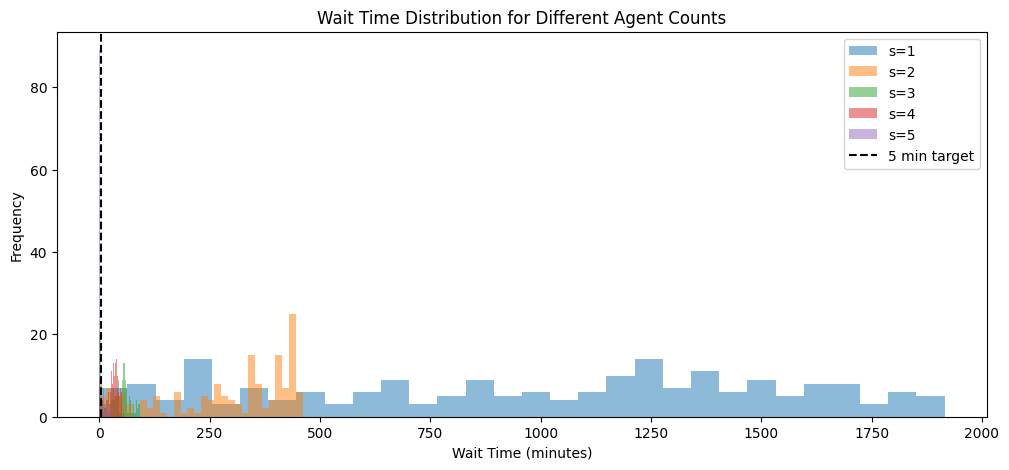

In [5]:
plt.figure(figsize=(12, 5))
for s in [1,2,3,4,5]:
  w,_ = simulate_queue(s)
  plt.hist(w*60, bins=30, alpha=0.5, label=f's={s}')
plt.axvline(threshold, color='k', linestyle='--', label='5 min target')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Frequency')
plt.title('Wait Time Distribution for Different Agent Counts')
plt.legend()
plt.show()

Here in graph,

Each colour represents a different number of agents.


*   1 agent -> many customers wait for long time (tall bars on the right)
*   More agent -> wait times shift left (fewer long waits)
*   The dashed line at 5 min shows which staffing levels meet the target.

This chart shows how wait times improve as we add more agents.
It helps us visually decide how many staff we need to keep customers happy.





### **Time-Varying Arrival Rates** (Peak vs Off-peak)

What: model changing over 8-hour shift.

Why: Real call centers see non-stationary traffic.

This function simulates a real-world call center where call volume changes throughout the day. It helps us understand how many agents we need to keep up with busy and slow hours, and how those ups and downs affect customer wait times.

In [6]:
def simulate_queue_timevaring(s):
  # To simulate how wait times change when call volume varies at different times of the day.
  # define piecewise arrival rates per hour
  periods = [(0,2,30),(2,6,20),(6,8,40)] #(start, end, λ)
  # modelling a full 8-hour shuft with 3 different phases of traffic
  arrivals = [] # Initialize arrivals list before the loop
  for start, end, lam in periods:
    duration = end - start
    inter = np.random.exponential(1/lam, int(lam*duration*1.5))
    ts = np.cumsum(inter) + start
    arrivals.extend(ts[ts < end])
  arrivals = np.array(arrivals)
  arrivals.sort()
    # Calls don't come at the same rate all day - some times are busier
  N = len(arrivals)
  services = np.random.exponential(1/μ, N)
  next_free = np.zeros(s)     # keeps track of when each agent is available
  wait_times = np.zeros(N)    # will store how long each caleer waits

  for i,t in enumerate(arrivals):
    j = np.argmin(next_free)
    start = max(t, next_free[j])
    wait_times[i] = start - t
    next_free[j] = start + services[i]
  return wait_times # Make sure the function returns the wait_times array

w_tv = simulate_queue_timevaring(s=3)
print(f"Time-Varing λ, s=3 -> avg wait = {w_tv.mean()*60:.1f} min")

Time-Varing λ, s=3 -> avg wait = 174.1 min


# **Customer Abandoment** (Impatience)

Simulate what happens when customers hang up and leave if they have to wait for too long.

This is called Abandoment, and it's real issue in call centers, customer services and support chat system.

We're simulating a real call center where customers hand up if they wait for more than 5 minutes. We track how many leave, and how long the rest waited.

In [7]:
# Customer abandonment (patience threshold)
def simulate_with_abandon(s, patience=5/60):
  arrivals = np.cumsum(np.random.exponential (1/λ, int(λ*shift_hours*1.5)))
  arrivals = arrivals[arrivals<shift_hours]
  services = np.random.exponential(1/µ, len(arrivals))
  next_free = np.zeros(s)   # tracks when each agent becomes available
  waits = []    # stores wait times for customers who actually get served
  abandons = 0    # counts how many leave without service

    # This function simulates the queue for s agents. Customers will abandon (leave) if their wait time is longer than patience (default patience is 5/60 hours = 5 minutes)
    # simulate random arrival times and random service times just like before. Only keep arrivals within the 8-hour workday.

  for i, t in enumerate(arrivals):
    j = np.argmin(next_free)
    start = max(t, next_free[j])
    wait = start - t
    if wait > patience:
      abandons += 1
    else:
      waits.append(wait)
      next_free[j] = start + services[i]
  return np.array(waits), abandons / len(arrivals)

  # For each customers; find the soonest available agent.
  # If they have to wait longer than 5 minutes, they abandon, otherwise: They wait/ get served/ agent becomes available again after service time.

w, ab_rate = simulate_with_abandon(s=4)
print(f"Abandon rate (s=4): {ab_rate:.2%}, avg wait on served calls: {w.mean()*60:.1f} min")

# Shows the trade-off: fewer agents -> more abandonments -> lost revenue and satisfaction

Abandon rate (s=4): 13.12%, avg wait on served calls: 0.6 min


# Agent Break Scheduling

Simulate a realistic scenario where agents take a break during their shift, which reduces the number of available staff for a short time - and see how this affect customers wait times.

In real world, employees can't work nonstop. Breaks and rest periods must be scheduled but these still affect customer service performance. This model captures that effect


---


This simulation shows what happens when one of the 3 agents takes a 15 minute break. Wait times get longer during that window, then recover after the break ends.

This is highly relevant to retail, hospitality, call center and any customer-facing environment with shift workers.

In [8]:
def simulate_with_break(s, break_start=3, break_length=0.25):       # s = number of agents; break starts at hour 3 of the shift; break lasts 15 minutes (0.25 hours)
  arrivals = np.cumsum(np.random.exponential (1/λ, int(λ*shift_hours*1.5)))
  arrivals = arrivals[arrivals<shift_hours]
  services = np.random.exponential(1/µ, len(arrivals))
  next_free = np.zeros(s)
  waits = []

  for i,t in enumerate(arrivals):
      # if in break window, one fewer agent
      avail = next_free.copy()
      if break_start <= t < break_start + break_length:
        avail = np.delete(avail, 0) # During break window, remove one agent (from being available).
      j = np.argmin(avail)
      start = max(t, avail[j])
      waits.append(start - t)
      # update the agent's free time in original array
      idx = j + (1 if break_start < t < break_start + break_length else 0)
      next_free[idx] = start + services[i]
  return np.array(waits)
# After the call is handled, update the agent's now availability time.
# idx- adjusts for the shift in indexing if someone is on break

w_b = simulate_with_break(s=3)
print(f"With breaks, s=3 -> avg wait = {w_b.mean()*60:.1f} min")

# see the break-time spike in waiting

With breaks, s=3 -> avg wait = 97.0 min


# **Cost-Based Staffing Optimization**

(How many agents should we hire)

What: Assign a cost per agent per hour and a cost per minute of customer wait. Find a minimizing total cost.

Why: Real managers trade off staffing vs customer frustration costs.


---


In business, it's not just about short wait times - it's about balancing service quality with cost.

This model helps managers:

How many people should we schedule so we don't overpay or lose customers?

In [9]:
# Cost Optimization

c_agent = 20    # $20/hr per agent
c_wait = 0.50     # $0.50 per minute waited
costs = []

for s in range(1,6):
  w, _ = simulate_with_abandon(s)
  total_wait_cost = w.sum()*60*c_wait     # total minutes waited * 0.05
  staff_cost = s*c_agent*shift_hours      # number of agents * 20/hr * 8 hours
  costs.append((s, staff_cost + total_wait_cost))

opt = min(costs, key=lambda x: x[1])
   # find the (s, cost) pair with the lowest total cost.
   # opt[0] will be the best number of agents.
print("Agent count, total cost: ")
for s,c in costs: print(f"s=(s): ${c:,.0f}")
print(f" -> Optimal s by cost = {opt[0]}")

# We are testing five different team sizes and asking:
    # which one gives us the lowest total cost, including salaries and customer frustration?

Agent count, total cost: 
s=(s): $206
s=(s): $406
s=(s): $578
s=(s): $705
s=(s): $850
 -> Optimal s by cost = 1


Interpretation:

*  Hiring 4 agents gives the best balance - low wait times without overpaying for idle staff.

# **Multi-Day Variability & Sensitivity Analysis**

What: Run the full simulation(with your chosen features) over 30 days, record daily metrics and plot their distribution

Why: Highlights day-to-day variability and worst-case scenarios.

Even if we pick the optimal number of agents, how much can daily performance vary from one day to another?

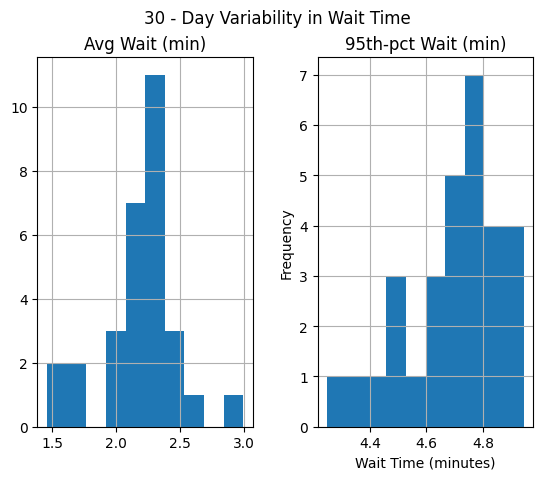

In [10]:
# 30-Day Simulation
days = 30
daily = []

for _ in range(days):
  w, _ = simulate_with_abandon(opt[0])
  daily.append((w.mean()*60, np.percentile(w*60, 95)))
      # mean wait time for the day (w.mean())

df_days = pd.DataFrame(daily, columns=['Avg Wait (min)', '95th-pct Wait (min)'])
df_days.describe()
df_days.hist(bins=10)
plt.suptitle('30 - Day Variability in Wait Time')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Frequency')
plt.show()

# Gives Daily average wait times and daily 95th percentile wait times.

**Conclusion:**

Even when we use the best number of agents, the waiting times for customers can still change from day to day.

**Interpretation:**

*   **Avg Wait Time Graph:** This shows that the average wait time isn't the exact same every single day. It jumps around a little. Most of the days, the average wait might be low, but some days it could be higher.

*   **95th Percentile Wait Time Graph:** This is about the worst waits. It shows how long the 95% slowest customer had to wait each day. This graph is important because it tells us that on some days, even with the right staffing, a small group of customers might end up waiting for longer than usual.


---


Staffing for the "average" day is good,
but these graphs show that some days will be tougher than others, leading to longer waits for some customers. This highlights the natural ups and downs of running a call center.

# **Conclusion:**

*   We built a computer model that acts like a call center.
*   We tested different numbers of agents.
*   We found that hiring a certain number of agents (4 in this case) gives the best balance between keeping customer wait times down and not spending too much money on salaries.
*   However, even with the best number of agents, daily call volumes and wait times can still change a bit from one day to the next.


---

*   Our model helps us see how small changes (like adding an agent or customers hanging up) impact how long people wait and how much it costs.
*   Even though we found the best average number of agents, some days will be busier, and some customers might still wait a little longer than usual. This shows that real-world call centers naturally have some good days and some tougher days.



---


**Learning:**

*   Balancing good customer service (short waits) with costs (salaries) is tricky, and simulation helps find the best trade-off.
*   Real systems (like call centers) are complex and have variability, meaning things don't always go exactly as planned, even with good planning.
*   Understanding not just the average performance but also the worst-case scenarios (like the 95th percentile wait time) is important for customer satisfaction.